In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from functools import reduce
import pickle
import itertools
from tqdm.notebook import trange, tqdm
from concurrent import futures
from joblib import delayed, Parallel
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from qgrid import show_grid
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, PowerTransformer, RobustScaler

In [2]:
DATA_ROOT = "../data/"

In [3]:
name_map_df = pd.read_csv(f"../../../SangerDrug/data/misc/uniprot_human_idmap.tab.gz",
                       sep='\t')
name_map_dict = name_map_df.set_index("Entry name").to_dict()['Gene names  (primary )']
protein2rna_map = name_map_dict
rna2protein_map = name_map_df.set_index("Gene names  (primary )").to_dict()['Entry name']

# map protein name

In [10]:
protein_df = pd.read_csv(
    f"../data/raw/e0022_diann_051021_frozen_matrix_averaged_processed.txt",
    sep='\t',
    index_col=0)


In [23]:
protein_df = protein_df[[
    x for x in protein_df.columns
    if x in protein2rna_map.keys() and type(protein2rna_map[x]) is str
]]

In [25]:
protein_df.columns = [protein2rna_map[x] for x in protein_df.columns]

In [26]:
protein_df = protein_df[sorted(protein_df.columns)]

In [28]:
protein_df.to_csv("../data/processed/protein.csv.gz")

# Sanger omic data

## combine all data

In [13]:
mutation_df = pd.read_csv("../data/raw/WES_variants_processed.csv", index_col=0)
rna_df = pd.read_csv("../data/raw/rna_processed.csv", index_col=0)
cnv_df = pd.read_csv("../data/raw/copynumber_processed.csv", index_col=0)
# methy_df = pd.read_csv("../data/raw/methy_processed.csv", index_col=0)
protein_df = pd.read_csv("../data/processed/protein.csv.gz", index_col=0)

In [14]:
mutation_df.columns = [f"{x}_mutation" for x in mutation_df.columns]
rna_df.columns = [f"{x}_rna" for x in rna_df.columns]
cnv_df.columns = [f"{x}_cnv" for x in cnv_df.columns]
# methy_df.columns = [f"{x}_methy" for x in methy_df.columns]
protein_df.columns = [f"{x}_prot" for x in protein_df.columns]

In [15]:
dfList_noprot = [mutation_df, cnv_df, rna_df]
df_intersection_noprot = reduce(
    lambda df1, df2: pd.merge(df1, df2, on='Cell_line', how='inner'),
    dfList_noprot)
df_union_noprot = reduce(lambda df1,df2: pd.merge(df1,df2,on='Cell_line',how='outer'), dfList_noprot)

In [ ]:
df_intersection_noprot.to_csv("../data/processed/omics/sanger_df_intersection_noprot_drug.csv.gz")
df_union_noprot.to_csv("../data/processed/omics/sanger_df_union_noprot_drug.csv.gz")


In [17]:
dfList = [mutation_df, cnv_df, rna_df, protein_df]
df_intersection = reduce(
    lambda df1, df2: pd.merge(df1, df2, on='Cell_line', how='inner'),
    dfList)
df_union = reduce(lambda df1,df2: pd.merge(df1,df2,on='Cell_line',how='outer'), dfList)

In [ ]:
df_intersection_noprot.to_csv("../data/processed/omics/sanger_df_intersection_noprot_drug.csv.gz")


In [9]:
df_intersection_noprot = pd.read_csv("../data/processed/omics/sanger_df_intersection_noprot_drug.csv.gz")

In [10]:
df_intersection = pd.read_csv("../data/processed/omics/sanger_df_intersection_mutation_cnv_rna_prot_drug.csv.gz")

## Sanger drug

In [14]:
df_intersection_noprot = pd.read_csv(
    "../data/processed/omics/sanger_df_intersection_noprot_drug.csv.gz",
    index_col=0)

In [15]:
sanger_drug = pd.read_csv("../data/raw/drug_final_processed_eg_id.csv.gz", low_memory=False)

In [16]:
sanger_drug_intersection_noprot = sanger_drug[sanger_drug['model_name'].isin(df_intersection_noprot.index)]

/Users/scai/anaconda3/envs/sanger/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


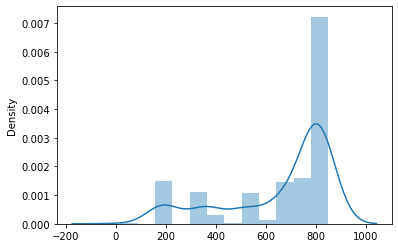

In [33]:
sns.distplot(sanger_drug_intersection_noprot.groupby('drug_id').size().values)

In [34]:
sanger_drug_intersection_noprot_size = sanger_drug_intersection_noprot.groupby('drug_id').size()
sanger_drug_intersection_noprot = sanger_drug_intersection_noprot[
    sanger_drug_intersection_noprot['drug_id'].isin(sanger_drug_intersection_noprot_size[
        sanger_drug_intersection_noprot_size > 600].index.values)]

In [35]:
sanger_drug_intersection_noprot_wide = pd.pivot(
    sanger_drug_intersection_noprot[['cell_line_name', 'drug_id', 'ln_IC50']],
    index='cell_line_name',
    columns='drug_id')
sanger_drug_intersection_noprot_wide.columns = [
    x[1] for x in sanger_drug_intersection_noprot_wide.columns
]

In [36]:
sanger_drug_intersection_noprot_wide.index.name = 'Cell_line'

In [38]:
sanger_train_intersection_noprot, sanger_test_intersection_noprot = train_test_split(
    sanger_drug_intersection_noprot_wide.index.values,
    test_size=0.2,
    random_state=42,
    shuffle=True)

In [522]:
with open("../data/meta/sanger_gdsc_intersection_noprot_train.txt", "w") as outfile:
    outfile.write("\n".join(sanger_train_intersection_noprot))
with open("../data/meta/sanger_gdsc_intersection_noprot_test.txt", "w") as outfile:
    outfile.write("\n".join(sanger_test_intersection_noprot))

In [538]:
sanger_drug_intersection_noprot_wide.to_csv(
    "../data/processed/drug/sanger_gdsc_intersection_noprot_wide.csv.gz")

### Jenny filter

In [20]:
sanger_drug_intersection_noprot_wide = pd.read_csv(
    "../data/processed/drug/sanger_gdsc_intersection_noprot_wide.csv.gz")

In [27]:
gdsc2_drugs = [x for x in sanger_drug_intersection_noprot_wide.columns if 'GDSC2' in x]

In [28]:
gdsc1_drugs = [x for x in sanger_drug_intersection_noprot_wide.columns if 'GDSC1' in x]

In [31]:
len(gdsc1_drugs)

330

In [26]:
len(selected_drugs)

219

In [ ]:
jenny_list = ['5-Fluorouracil']

In [ ]:
[x for x in selected_drugs if x.split(';')[1] in jenny_list]

### sanger_drug_intersection_noprot binary

In [6]:
sanger_drug_intersection3_wide = pd.read_csv(
    "../data/processed/drug/sanger_gdsc_intersection_noprot_wide.csv.gz",
    index_col=0)

In [10]:
sanger_drug_intersection3_wide.apply(lambda col:np.nanmedian(col),axis=0)

1001;AICA Ribonucleotide;GDSC1    7.703511
1003;Camptothecin;GDSC2          -2.418375
1004;Vinblastine;GDSC1           -4.225736
1004;Vinblastine;GDSC2           -3.952339
1005;Cisplatin;GDSC1              2.745476
                                    ...   
562;AGI-6780;GDSC1                1.445610
563;Kobe2602;GDSC1                4.458120
573;LGK974;GDSC1                  2.644233
574;Wnt-C59;GDSC1                 2.568679
576;RU-SKI 43;GDSC1               4.590855
Length: 549, dtype: float64

In [58]:
sanger_drug_intersection3_wide

,1001;AICA Ribonucleotide;GDSC1,1003;Camptothecin;GDSC2,1004;Vinblastine;GDSC1,1004;Vinblastine;GDSC2,1005;Cisplatin;GDSC1,1005;Cisplatin;GDSC2,1006;Cytarabine;GDSC1,1006;Cytarabine;GDSC2,1007;Docetaxel;GDSC1,1007;Docetaxel;GDSC2,...,476;SB505124;GDSC1,477;A-83-01;GDSC1,478;LDN-193189;GDSC1,546;FTY-720;GDSC1,552;BAM7;GDSC1,562;AGI-6780;GDSC1,563;Kobe2602;GDSC1,573;LGK974;GDSC1,574;Wnt-C59;GDSC1,576;RU-SKI 43;GDSC1
Cell_line,,,,,,,,,,,,,,,,,,,,,
201T,10.006219,-3.123765,-4.519928,NaN,1.739354,NaN,-1.811303,NaN,-5.948871,-5.263725,...,5.497642,5.577882,2.041223,4.314062,5.830343,2.031241,5.668086,3.814942,3.374751,5.759942
22RV1,8.277717,-2.711064,-4.388238,-4.358934,3.133420,3.760772,0.208333,4.506211,-5.726998,-3.534340,...,2.062433,5.301060,0.504329,2.534243,3.358727,2.074554,5.516358,2.970851,2.382256,4.611802
23132-87,8.505091,-2.633188,-4.570881,-4.745928,3.980032,4.083907,-1.689554,0.089204,-5.207581,-4.802981,...,3.455451,5.373237,1.386745,2.876781,4.940830,1.809987,4.688832,2.986543,3.390533,4.273043
42-MG-BA,7.562601,-3.393686,-4.640558,-4.748196,3.013673,2.247032,0.008112,1.105481,-6.773613,-4.954833,...,2.794244,3.794006,0.767780,2.940470,4.235138,1.303975,5.359481,2.917454,2.468938,5.487908
5637,8.011646,-2.571851,-6.611545,NaN,1.521328,2.303510,-0.877628,2.578905,-8.391204,-6.011902,...,5.169427,3.848002,1.335373,1.864092,4.640307,1.128211,4.779121,2.786563,2.531710,4.479116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YAPC,9.325459,-1.517331,-2.234043,-0.276878,5.582824,6.191892,1.455560,2.117056,-4.664836,-1.789328,...,4.355866,3.962664,1.338727,2.656372,5.354368,2.533823,6.013006,3.626296,3.168425,6.192931
YH-13,9.043443,-1.491516,-5.476767,-5.392334,2.439968,3.297034,-1.352299,0.686480,-6.828457,-5.753114,...,4.985660,4.281812,0.417354,2.614606,4.417950,1.001159,5.102382,3.311944,3.479282,5.424028
YKG-1,6.477157,-2.652776,-4.975824,NaN,1.867132,NaN,-1.249552,NaN,-6.986876,-4.586049,...,3.445554,4.390702,0.381487,2.550901,4.454684,1.936417,4.226052,2.414651,2.191717,4.367968


In [60]:
sanger_drug_intersection3_wide_binary = sanger_drug_intersection3_wide < sanger_drug_intersection3_wide.apply(
    lambda col: np.nanmedian(col), axis=0)

sanger_drug_intersection3_wide_binary = sanger_drug_intersection3_wide_binary.astype(int)

sanger_drug_intersection3_wide_binary[sanger_drug_intersection3_wide.isna()] = np.nan

In [62]:
sanger_drug_intersection3_wide_binary

,1001;AICA Ribonucleotide;GDSC1,1003;Camptothecin;GDSC2,1004;Vinblastine;GDSC1,1004;Vinblastine;GDSC2,1005;Cisplatin;GDSC1,1005;Cisplatin;GDSC2,1006;Cytarabine;GDSC1,1006;Cytarabine;GDSC2,1007;Docetaxel;GDSC1,1007;Docetaxel;GDSC2,...,476;SB505124;GDSC1,477;A-83-01;GDSC1,478;LDN-193189;GDSC1,546;FTY-720;GDSC1,552;BAM7;GDSC1,562;AGI-6780;GDSC1,563;Kobe2602;GDSC1,573;LGK974;GDSC1,574;Wnt-C59;GDSC1,576;RU-SKI 43;GDSC1
Cell_line,,,,,,,,,,,,,,,,,,,,,
201T,0.0,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22RV1,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
23132-87,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
42-MG-BA,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
5637,0.0,1.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YAPC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YH-13,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
YKG-1,1.0,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0


In [39]:
sanger_drug_intersection3_wide_binary.to_csv(
    "../data/processed/drug/sanger_gdsc_intersection_noprot_wide_binary.csv.gz")

## CTD drug

In [ ]:
meta = pd.read_csv("../data/meta/model_list_20210427.csv")

meta = meta[meta['model_name'].isin(df_intersection_noprot.index.values)]

sidm_to_name = meta.set_index('model_id').to_dict()['model_name']

ctd_drug = pd.read_csv("../data/processed/drug/CTRPv2.0_AUC_parsed.csv.gz",
                       low_memory=False,
                       index_col=0).T
ctd_drug.index.name = 'Cell_line'

In [87]:
sidm_to_name = meta.set_index('model_id').to_dict()['model_name']

In [96]:
ctd_drug = pd.read_csv("../data/processed/drug/CTRPv2.0_AUC_parsed.csv.gz",
                       low_memory=False,
                       index_col=0).T
ctd_drug.index.name = 'Cell_line'

In [98]:
ctd_drug = ctd_drug[ctd_drug.index.isin(meta['model_id'])]

ctd_drug.index = ctd_drug.index.map(sidm_to_name)

In [125]:
ctd_meta_drug = pd.read_csv(
    "../data/raw/ctd2/CTRPv2.1_2016_pub_NatChemBiol_12_109/v21.meta.per_compound.txt",
    sep='\t')
drug_id_name = ctd_meta_drug.set_index('master_cpd_id').to_dict()['cpd_name']
ctd_meta_cell = pd.read_csv(
    "../data/raw/ctd2/CTRPv2.1_2016_pub_NatChemBiol_12_109/v21.meta.per_cell_line.txt",
    sep='\t')
cell_id_name = ctd_meta_cell.set_index('master_ccl_id').to_dict()['ccl_name']

ctd_drug_raw = pd.read_csv(
    "../data/raw/ctd2/CTRPv2.1_2016_pub_NatChemBiol_12_109/v21.data.auc_sensitivities.txt",
    sep='\t')

ctd_drug_raw['Cell_line'] = ctd_drug_raw['master_ccl_id'].map(cell_id_name)
ctd_drug_raw['drug_id'] = ctd_drug_raw['master_cpd_id'].map(drug_id_name)
ctd_drug_raw = ctd_drug_raw.drop_duplicates(['Cell_line', 'drug_id'])


In [139]:
ctd_drug_filtered = ctd_drug_raw[ctd_drug_raw['Cell_line'].isin(meta['model_name'])]

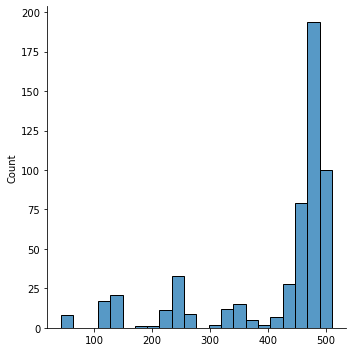

In [114]:
sns.displot(ctd_drug.shape[0] - pd.isna(ctd_drug).sum(axis=0))

In [116]:
ctd_drug.dropna(thresh=400,axis=1).to_csv("../data/processed/drug/sanger_ctd2_min400.csv.gz")

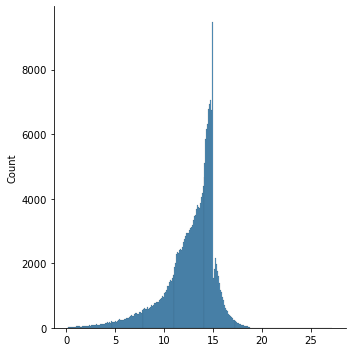

In [118]:
sns.displot(ctd_drug.values.flatten())

In [103]:
ctd_drug.columns

Index(['16-BETA-BROMOANDROSTERONE', '1S,3R-RSL-3', '3-CL-AHPC', '968',
       'A-804598', 'AA-COCF3', 'ABIRATERONE', 'ABT-199', 'ABT-737', 'AC55649',
       ...
       'WAY-362450', 'WP1130', 'WZ4002', 'WZ8040', 'XL765', 'YK 4-279', 'YL54',
       'YM-155', 'ZEBULARINE', 'ZSTK474'],
      dtype='object', name='master_cpd_id', length=545)

# CCLE omic data

In [ ]:
ctd_drug = ctd_drug[set(ctd_drug.columns).intersection(sidm_to_name.keys())]

In [30]:
ccle_meta = pd.read_csv("../data/meta/ccle_sample_info.csv")

## load omic

In [ ]:
sanger_drug_intersection_noprot_wide = pd.pivot(
    sanger_drug_intersection_noprot[['cell_line_name', 'drug_id', 'ln_IC50']],
    index='cell_line_name',
    columns='drug_id')

In [31]:
mutation = pd.read_csv("../data/ccle/CCLE_mutations.csv", low_memory=False)

mutation = mutation[mutation['Variant_annotation']=='damaging']

mutation_count = mutation.groupby(['DepMap_ID', 'Hugo_Symbol']).size().reset_index(name='count')

mutation_count = pd.pivot(mutation_count, index='DepMap_ID', columns='Hugo_Symbol').fillna(0)

mutation_count.columns = [x[1] for x in mutation_count.columns]

mutation_count = mutation_count.sort_values(by='DepMap_ID')

In [32]:
cnv = pd.read_csv("../data/ccle/CCLE_gene_cn.csv", index_col=0)

cnv.index.name = 'DepMap_ID'

cnv.columns = [x.split(' ')[0] for x in cnv.columns]

cnv = cnv[sorted(cnv.columns)]
cnv = cnv.sort_values(by='DepMap_ID')

In [33]:
rna = pd.read_csv("../data/ccle/CCLE_expression.csv", index_col=0)

rna.index.name = 'DepMap_ID'

rna.shape

rna.columns = [x.split(' ')[0] for x in rna.columns]

rna = rna[sorted(rna.columns)]
rna = rna.sort_values(by='DepMap_ID')


In [34]:
sample = pd.read_csv("../data/ccle/sample_info.csv")

ccle2depmap = sample.set_index(['CCLE_Name']).to_dict()['DepMap_ID']

In [35]:
protein = pd.read_csv("../data/ccle/protein_quant_current_normalized.csv.gz")

protein = protein.drop(
    ['Protein_Id', 'Gene_Symbol', 'Description', 'Group_ID', 'Uniprot_Acc'],
    axis=1).rename(columns={
        'Uniprot': 'Protein'
    }).set_index('Protein')
protein = protein.drop([
    'SW948_LARGE_INTESTINE_TenPx11', 'CAL120_BREAST_TenPx02',
    'HCT15_LARGE_INTESTINE_TenPx30'
],
                       axis=1)

rename_dict = {}
for x in protein.columns.to_list():
    rename_dict[x] = x.split('_TenPx')[0]
protein = protein.rename(columns=rename_dict)
protein = protein.drop([x for x in protein.columns.tolist() if 'TenPx' in x],
                       axis=1).transpose()

protein.index.name = 'CCLE_ID'

protein.index = protein.index.map(ccle2depmap)
protein.index.name = 'DepMap_ID'

protein = protein.loc[:, ~protein.columns.duplicated()]
protein = protein[[
    x for x in protein.columns
    if x in protein2rna_map and type(protein2rna_map[x]) is str
]]
protein.columns = [protein2rna_map[x] for x in protein.columns]
# protein = protein.loc[:,~protein.columns.duplicated()]

protein = protein[sorted(protein.columns)]
protein = protein.sort_values(by='DepMap_ID')

## max conc filter

In [11]:
df_intersection_noprot = pd.read_csv(
    "../data/processed/omics/sanger_df_intersection_noprot_drug.csv.gz",
    index_col=0)

In [39]:
sanger_drug = pd.read_csv("../data/raw/drug_final_processed_eg_id.csv.gz", low_memory=False)

In [40]:
sanger_drug_intersection_noprot = sanger_drug[sanger_drug['model_name'].isin(df_intersection_noprot.index)]

In [41]:
sanger_drug['max_screening_conc'] = sanger_drug['max_screening_conc'].map(np.log)
drug_counts = pd.DataFrame({
    'below_max':
    sanger_drug.query("ln_IC50 < max_screening_conc").groupby('drug_id').size(),
    'all':
    sanger_drug.groupby('drug_id').size()
}).fillna(0)
drug_counts['ratio'] = drug_counts['below_max'] / drug_counts['all']

sanger_drug_intersection_noprot = sanger_drug_intersection_noprot[
    sanger_drug_intersection_noprot['drug_id'].isin(
        drug_counts[drug_counts['ratio'] > 0.2].index)]

/Users/scai/anaconda3/envs/sanger/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


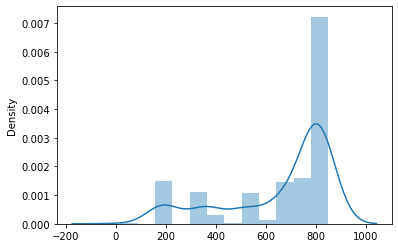

In [42]:
sns.distplot(sanger_drug_intersection_noprot.groupby('drug_id').size().values)

In [43]:
sanger_drug_intersection_noprot_size = sanger_drug_intersection_noprot.groupby('drug_id').size()
sanger_drug_intersection_noprot = sanger_drug_intersection_noprot[
    sanger_drug_intersection_noprot['drug_id'].isin(sanger_drug_intersection_noprot_size[
        sanger_drug_intersection_noprot_size > 600].index.values)]

In [44]:
sanger_drug_intersection_noprot_wide = pd.pivot(
    sanger_drug_intersection_noprot[['cell_line_name', 'drug_id', 'ln_IC50']],
    index='cell_line_name',
    columns='drug_id')
sanger_drug_intersection_noprot_wide.columns = [
    x[1] for x in sanger_drug_intersection_noprot_wide.columns
]

In [45]:
sanger_drug_intersection_noprot_wide.index.name = 'Cell_line'

In [46]:
sanger_train_intersection_noprot, sanger_test_intersection_noprot = train_test_split(
    sanger_drug_intersection_noprot_wide.index.values,
    test_size=0.2,
    random_state=42,
    shuffle=True)

In [48]:
with open("../data/meta/sanger_gdsc_intersection_noprot_maxcfilter_train.txt", "w") as outfile:
    outfile.write("\n".join(sanger_train_intersection_noprot))
with open("../data/meta/sanger_gdsc_intersection_noprot_maxcfilter_test.txt", "w") as outfile:
    outfile.write("\n".join(sanger_test_intersection_noprot))

In [49]:
sanger_drug_intersection_noprot_wide.to_csv(
    "../data/processed/drug/sanger_gdsc_intersection_noprot_maxcfilter_wide.csv.gz")

## merge

In [37]:
sanger_mapping = pd.read_csv(
    "../../../SangerDrug/data/E0022_P06_final_sample_map_no_control.txt",
    sep='\t').drop_duplicates(['Cell_line'])
sidm_to_cellline = sanger_mapping.set_index('SIDM').to_dict()['Cell_line']


sample['Cell_line'] = sample['Sanger_Model_ID'].map(sidm_to_cellline)

depmapid_to_cellline = sample.set_index('DepMap_ID').to_dict()['Cell_line']
depmapid_to_cellline_strip = sample.set_index('DepMap_ID').to_dict()['stripped_cell_line_name']

In [38]:
mutation_count.columns = [f"{x}_mutation" for x in mutation_count.columns]
cnv.columns = [f"{x}_cnv" for x in cnv.columns]
rna.columns = [f"{x}_rna" for x in rna.columns]
protein.columns = [f"{x}_prot" for x in protein.columns]

In [39]:
# dfList = [mutation_count, cnv, rna, protein]
dfList = [mutation_count, cnv, rna, protein]
dfList3 = [mutation_count, cnv, rna]

df_intersection = reduce(
    lambda df1, df2: pd.merge(df1, df2, on='DepMap_ID', how='inner'), dfList)
df_union = reduce(
    lambda df1, df2: pd.merge(df1, df2, on='DepMap_ID', how='outer'), dfList)
df_intersection3 = reduce(
    lambda df1, df2: pd.merge(df1, df2, on='DepMap_ID', how='inner'), dfList3)

In [469]:
df_intersection['Cell_line'] = df_intersection.index.map(depmapid_to_cellline)
df_intersection = df_intersection.dropna(subset=['Cell_line'])

df_union['Cell_line'] = df_union.index.map(depmapid_to_cellline)
df_union = df_union.dropna(subset=['Cell_line'])

df_intersection3['Cell_line'] = df_intersection3.index.map(depmapid_to_cellline)
df_intersection3 = df_intersection3.dropna(subset=['Cell_line'])

df_intersection = df_intersection.set_index('Cell_line')
df_union = df_union.set_index('Cell_line')
df_intersection3 = df_intersection3.set_index('Cell_line')

In [188]:
df_intersection3['Cell_line'] = df_intersection3.index.map(depmapid_to_cellline_strip)
df_intersection3 = df_intersection3.dropna(subset=['Cell_line'])
df_intersection3 = df_intersection3.set_index('Cell_line')

In [470]:
df_union = df_union.loc[:,~df_union.columns.duplicated()]
df_intersection = df_intersection.loc[:,~df_intersection.columns.duplicated()]
df_intersection3 = df_intersection3.loc[:,~df_intersection3.columns.duplicated()]

In [474]:
df_union.to_csv("../data/processed/ccle_df_union_drug.csv.gz")

df_intersection.to_csv("../data/processed/ccle_df_intersection_drug.csv.gz")

df_intersection3.to_csv("../data/processed/ccle_df_intersection3_drug.csv.gz")

In [194]:
df_intersection3.to_csv("../data/processed/omics/ccle_df_intersection3_strip_name.csv.gz")

In [12]:
df_intersection3 = pd.read_csv("../data/processed/omics/ccle_df_intersection3_drug.csv.gz")

In [4]:
df_intersection = pd.read_csv("../data/processed/omics/ccle_df_intersection_drug.csv.gz")

## sanger drug data

In [384]:
sanger_drug = pd.read_csv("../data/raw/drug_final_processed_eg_id.csv.gz", low_memory=False)

In [397]:
sanger_drug_intersection = sanger_drug[sanger_drug['model_name'].isin(df_intersection.index)]
sanger_drug_intersection3 = sanger_drug[sanger_drug['model_name'].isin(df_intersection3.index)]

sanger_drug_union = sanger_drug[sanger_drug['model_name'].isin(df_union.index)]

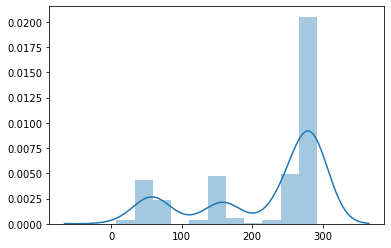

In [387]:
sns.distplot(sanger_drug_intersection.groupby('drug_id').size().values)

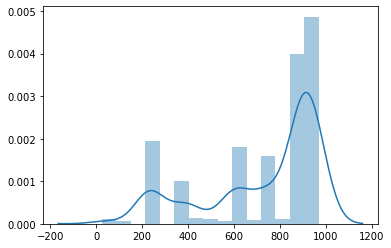

In [388]:
sns.distplot(sanger_drug_union.groupby('drug_id').size().values)

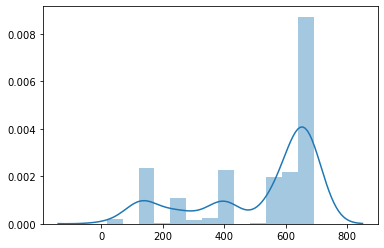

In [480]:
sns.distplot(sanger_drug_intersection3.groupby('drug_id').size().values)

In [398]:
sanger_drug_intersection_size = sanger_drug_intersection.groupby('drug_id').size()
sanger_drug_intersection = sanger_drug_intersection[
    sanger_drug_intersection['drug_id'].isin(sanger_drug_intersection_size[
        sanger_drug_intersection_size > 200].index.values)]

sanger_drug_union_size = sanger_drug_union.groupby('drug_id').size()
sanger_drug_union = sanger_drug_union[
    sanger_drug_union['drug_id'].isin(sanger_drug_union_size[
        sanger_drug_union_size > 600].index.values)]

sanger_drug_intersection3_size = sanger_drug_intersection3.groupby('drug_id').size()
sanger_drug_intersection3 = sanger_drug_intersection3[
    sanger_drug_intersection3['drug_id'].isin(sanger_drug_intersection3_size[
        sanger_drug_intersection3_size > 500].index.values)]

In [405]:
sanger_drug_intersection_wide = pd.pivot(
    sanger_drug_intersection[['cell_line_name', 'drug_id', 'ln_IC50']],
    index='cell_line_name',
    columns='drug_id')
sanger_drug_intersection_wide.columns = [x[1] for x in sanger_drug_intersection_wide.columns]

sanger_drug_union_wide = pd.pivot(
    sanger_drug_union[['cell_line_name', 'drug_id', 'ln_IC50']],
    index='cell_line_name',
    columns='drug_id')
sanger_drug_union_wide.columns = [x[1] for x in sanger_drug_union_wide.columns]

sanger_drug_intersection3_wide = pd.pivot(
    sanger_drug_intersection3[['cell_line_name', 'drug_id', 'ln_IC50']],
    index='cell_line_name',
    columns='drug_id')
sanger_drug_intersection3_wide.columns = [x[1] for x in sanger_drug_intersection3_wide.columns]


In [416]:
sanger_drug_intersection_wide.index.name = 'Cell_line'
sanger_drug_union_wide.index.name = 'Cell_line'
sanger_drug_intersection3_wide.index.name = 'Cell_line'


In [408]:
ccle_train_intersection, ccle_test_intersection = train_test_split(
    sanger_drug_intersection_wide.index.values,
    test_size=0.2,
    random_state=42,
    shuffle=True)

In [409]:
ccle_train_union, ccle_test_union = train_test_split(
    sanger_drug_union_wide.index.values,
    test_size=0.2,
    random_state=42,
    shuffle=True)

In [485]:
ccle_train_intersection3, ccle_test_intersection3 = train_test_split(
    sanger_drug_intersection3_wide.index.values,
    test_size=0.2,
    random_state=42,
    shuffle=True)

In [419]:
with open("../data/meta/ccle_gdsc_intersection_train.txt", "w") as outfile:
    outfile.write("\n".join(ccle_train_intersection))
with open("../data/meta/ccle_gdsc_intersection_test.txt", "w") as outfile:
    outfile.write("\n".join(ccle_test_intersection))

In [420]:
with open("../data/meta/ccle_gdsc_union_train.txt", "w") as outfile:
    outfile.write("\n".join(ccle_train_union))
with open("../data/meta/ccle_gdsc_union_test.txt", "w") as outfile:
    outfile.write("\n".join(ccle_test_union))

In [487]:
with open("../data/meta/ccle_gdsc_intersection3_train.txt", "w") as outfile:
    outfile.write("\n".join(ccle_train_intersection3))
with open("../data/meta/ccle_gdsc_intersection3_test.txt", "w") as outfile:
    outfile.write("\n".join(ccle_test_intersection3))

In [418]:
sanger_drug_intersection_wide.to_csv("../data/processed/ccle_gdsc_intersection_wide.csv.gz")

sanger_drug_union_wide.to_csv("../data/processed/ccle_gdsc_union_wide.csv.gz")

In [488]:
sanger_drug_intersection3_wide.to_csv("../data/processed/ccle_gdsc_intersection3_wide.csv.gz")


## CTD drug

In [144]:
df_intersection3 = pd.read_csv("../data/processed/omics/ccle_df_intersection3_strip_name.csv.gz")

In [157]:
ctd_meta_drug = pd.read_csv(
    "../data/raw/ctd2/CTRPv2.1_2016_pub_NatChemBiol_12_109/v21.meta.per_compound.txt",
    sep='\t')
drug_id_name = ctd_meta_drug.set_index('master_cpd_id').to_dict()['cpd_name']
ctd_meta_cell = pd.read_csv(
    "../data/raw/ctd2/CTRPv2.1_2016_pub_NatChemBiol_12_109/v21.meta.per_cell_line.txt",
    sep='\t')
cell_id_name = ctd_meta_cell.set_index('master_ccl_id').to_dict()['ccl_name']

ctd_drug_raw = pd.read_csv(
    "../data/raw/ctd2/CTRPv2.1_2016_pub_NatChemBiol_12_109/v21.data.auc_sensitivities.txt",
    sep='\t')

ctd_drug_raw['Cell_line'] = ctd_drug_raw['master_ccl_id'].map(cell_id_name)
ctd_drug_raw['drug_id'] = ctd_drug_raw['master_cpd_id'].map(drug_id_name)
ctd_drug_raw = ctd_drug_raw.drop_duplicates(['Cell_line', 'drug_id'])


In [200]:
ctd_drug_ccle = ctd_drug_raw[ctd_drug_raw['Cell_line'].isin(df_intersection3.index)]

In [203]:
ctd_drug_ccle_wide = pd.pivot(
    ctd_drug_ccle[['Cell_line', 'drug_id', 'area_under_curve']],
    index='Cell_line',
    columns='drug_id')

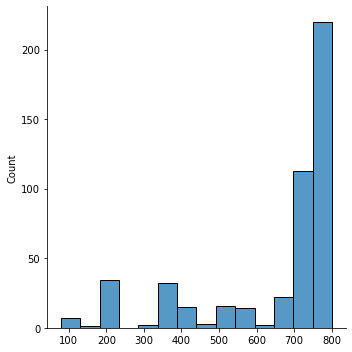

In [205]:
sns.displot(ctd_drug_ccle_wide.shape[0] -
            pd.isna(ctd_drug_ccle_wide).sum(axis=0))

In [210]:
ctd_drug_ccle_wide.columns = [x[1] for x in ctd_drug_ccle_wide.columns]

In [212]:
ctd_drug_ccle_wide.dropna(thresh=600,axis=1).to_csv("../data/processed/drug/ccle_ctd2_min600.csv.gz")

## sanger drug maxcfilter

In [54]:
df_intersection3 = pd.read_csv(
    "../data/processed/omics/ccle_df_intersection3_drug.csv.gz", index_col=0)

In [50]:
sanger_drug = pd.read_csv("../data/raw/drug_final_processed_eg_id.csv.gz", low_memory=False)

In [55]:
sanger_drug['max_screening_conc'] = sanger_drug['max_screening_conc'].map(np.log)
drug_counts = pd.DataFrame({
    'below_max':
    sanger_drug.query("ln_IC50 < max_screening_conc").groupby('drug_id').size(),
    'all':
    sanger_drug.groupby('drug_id').size()
}).fillna(0)
drug_counts['ratio'] = drug_counts['below_max'] / drug_counts['all']

sanger_drug = sanger_drug[
    sanger_drug['drug_id'].isin(
        drug_counts[drug_counts['ratio'] > 0.2].index)]

In [56]:
sanger_drug_intersection3 = sanger_drug[sanger_drug['model_name'].isin(df_intersection3.index)]

/Users/scai/anaconda3/envs/sanger/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


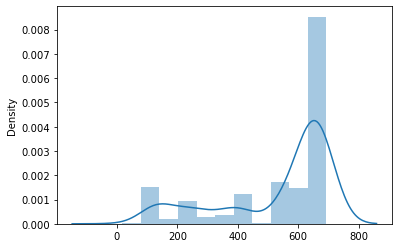

In [57]:
sns.distplot(sanger_drug_intersection3.groupby('drug_id').size().values)

In [58]:
sanger_drug_intersection3_size = sanger_drug_intersection3.groupby('drug_id').size()
sanger_drug_intersection3 = sanger_drug_intersection3[
    sanger_drug_intersection3['drug_id'].isin(sanger_drug_intersection3_size[
        sanger_drug_intersection3_size > 500].index.values)]

In [59]:
sanger_drug_intersection3_wide = pd.pivot(
    sanger_drug_intersection3[['cell_line_name', 'drug_id', 'ln_IC50']],
    index='cell_line_name',
    columns='drug_id')
sanger_drug_intersection3_wide.columns = [x[1] for x in sanger_drug_intersection3_wide.columns]


In [60]:
sanger_drug_intersection3_wide.index.name = 'Cell_line'

In [65]:
ccle_train_intersection3, ccle_test_intersection3 = train_test_split(
    sanger_drug_intersection3_wide.index.values,
    test_size=0.2,
    random_state=42,
    shuffle=True)

In [66]:
with open("../data/meta/ccle_gdsc_intersection3_maxcfilter_train.txt", "w") as outfile:
    outfile.write("\n".join(ccle_train_intersection3))
with open("../data/meta/ccle_gdsc_intersection3_maxcfilter_test.txt", "w") as outfile:
    outfile.write("\n".join(ccle_test_intersection3))

In [68]:
sanger_drug_intersection3_wide.to_csv("../data/processed/drug/ccle_gdsc_intersection3_maxcfilter_wide.csv.gz")


## strip cell line name for mixomics

# CCLE drug data

In [329]:
ccle_drug = pd.read_csv(
    "../data/ccle/secondary-screen-dose-response-curve-parameters.csv",
    low_memory=False)


In [330]:
ccle_drug = ccle_drug[ccle_drug['screen_id']=='HTS002']
ccle_drug = ccle_drug.drop_duplicates(['name', 'depmap_id'])
ccle_drug_intersection = ccle_drug[ccle_drug['depmap_id'].isin(
    df_intersection.index.values)].reset_index(drop=True)

ccle_drug_union = ccle_drug[ccle_drug['depmap_id'].isin(
    df_union.index.values)].reset_index(drop=True)

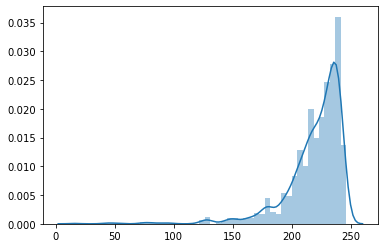

In [331]:
sns.distplot(ccle_drug_intersection.groupby('name').size().values)

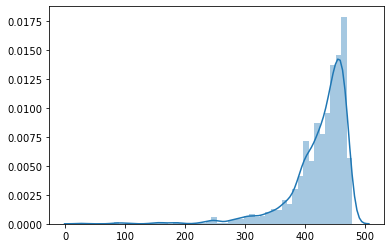

In [332]:
sns.distplot(ccle_drug_union.groupby('name').size().values)

In [333]:
ccle_drug_intersection_size = ccle_drug_intersection.groupby('name').size()
ccle_drug_intersection = ccle_drug_intersection[
    ccle_drug_intersection['name'].isin(ccle_drug_intersection_size[
        ccle_drug_intersection_size > 200].index.values)]

In [334]:
ccle_drug_union_size = ccle_drug_union.groupby('name').size()
ccle_drug_union = ccle_drug_union[
    ccle_drug_union['name'].isin(ccle_drug_union_size[
        ccle_drug_union_size > 400].index.values)]

In [345]:
ccle_drug_intersection_wide = pd.pivot(
    ccle_drug_intersection[['depmap_id', 'name', 'auc']],
    index='depmap_id',
    columns='name')
ccle_drug_intersection_wide.columns = [x[1] for x in ccle_drug_intersection_wide.columns]

ccle_drug_union_wide = pd.pivot(
    ccle_drug_union[['depmap_id', 'name', 'auc']],
    index='depmap_id',
    columns='name')
ccle_drug_union_wide.columns = [x[1] for x in ccle_drug_union_wide.columns]

In [347]:
ccle_drug_intersection_wide[
    'Cell_line'] = ccle_drug_intersection_wide.index.map(depmapid_to_cellline)
ccle_drug_intersection_wide = ccle_drug_intersection_wide.dropna(
    subset=['Cell_line'])

ccle_drug_union_wide['Cell_line'] = ccle_drug_union_wide.index.map(
    depmapid_to_cellline)
ccle_drug_union_wide = ccle_drug_union_wide.dropna(subset=['Cell_line'])

ccle_drug_intersection_wide = ccle_drug_intersection_wide.set_index(
    'Cell_line')
ccle_drug_union_wide = ccle_drug_union_wide.set_index('Cell_line')

In [364]:
ccle_drug_train_intersection, ccle_drug_test_intersection = train_test_split(
    ccle_drug_intersection_wide.index.values,
    test_size=0.2,
    random_state=42,
    shuffle=True)

ccle_drug_train_union, ccle_drug_test_union = train_test_split(
    ccle_drug_union_wide.index.values,
    test_size=0.2,
    random_state=42,
    shuffle=True)

In [368]:
with open("../data/meta/ccle_depmapdrug_intersection_train.txt", "w") as outfile:
    outfile.write("\n".join(ccle_drug_train_intersection))
with open("../data/meta/ccle_depmapdrug_intersection_test.txt", "w") as outfile:
    outfile.write("\n".join(ccle_drug_test_intersection))

In [369]:
with open("../data/meta/ccle_depmapdrug_union_train.txt", "w") as outfile:
    outfile.write("\n".join(ccle_drug_train_union))
with open("../data/meta/ccle_depmapdrug_union_test.txt", "w") as outfile:
    outfile.write("\n".join(ccle_drug_test_union))

In [417]:
ccle_drug_intersection_wide.to_csv("../data/processed/ccle_depmapdrug_intersection_wide.csv.gz")

ccle_drug_union_wide.to_csv("../data/processed/ccle_depmapdrug_union_wide.csv.gz")

# drug remove covariate

## no tissue

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score

In [8]:
cell_meta = pd.read_excel("../data/meta/SamplesheetApril2020.xlsx").rename(columns={'model_name':'Cell_line'})

In [163]:
drug_long = pd.read_csv("../data/raw/drug_final_processed_eg_id.csv.gz",
                        low_memory=False)

drug_long = drug_long.rename(columns={'model_name':'Cell_line'})

drug_wide = pd.read_csv("../data/processed/drug/sanger_gdsc_intersection_noprot_wide.csv.gz", index_col=0)

drug_long = drug_long[drug_long['Cell_line'].isin(drug_wide.index.values)]

In [171]:
drug_long_ann = pd.merge(
    drug_long,
    cell_meta[['Cell_line', 'growth', 'media']],
    on='Cell_line')

In [172]:
cell_mean_IC50 = drug_wide.mean(axis=1)

In [173]:
drug_long_ann['cell_mean_IC50'] = drug_long_ann['Cell_line'].map(lambda x:cell_mean_IC50[x])

In [199]:
drug_long_ann['growth'] = drug_long_ann['growth'].fillna(drug_long_ann['growth'].mean())

In [175]:
pd.get_dummies(
    drug_long_ann[['Cell_line', 'cell_mean_IC50', 'growth',
               'growth_properties', 'media']],
    columns=['growth_properties', 'media'])

,Cell_line,cell_mean_IC50,growth,growth_properties_Adherent,growth_properties_Semi-Adherent,growth_properties_Suspension,growth_properties_Unknown,media_D/F12,media_R
0,MC-CAR,1.467771,0.559769,0,0,1,0,1,0
1,MC-CAR,1.467771,0.559769,0,0,1,0,1,0
2,MC-CAR,1.467771,0.559769,0,0,1,0,1,0
3,MC-CAR,1.467771,0.559769,0,0,1,0,1,0
4,MC-CAR,1.467771,0.559769,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...
522614,SNU-283,3.109763,-0.332292,1,0,0,0,0,1
522615,SNU-283,3.109763,-0.332292,1,0,0,0,0,1
522616,SNU-283,3.109763,-0.332292,1,0,0,0,0,1
522617,SNU-283,3.109763,-0.332292,1,0,0,0,0,1


In [208]:
res_df = []
for drug_id in drug_wide.columns:
    drug_long_ann_tmp = drug_long_ann.query(f'drug_id == "{drug_id}"')

    drug_long_ann_tmp = pd.get_dummies(drug_long_ann_tmp[[
        'Cell_line', 'cell_mean_IC50', 'growth', 'growth_properties', 'media'
    ]],
                                   columns=['growth_properties', 'media'])
    drug_data = pd.merge(drug_long_ann_tmp, drug_wide[drug_id], on='Cell_line').set_index('Cell_line')
    X = drug_data.iloc[:, :-1]
    y = drug_data.iloc[:, -1]
    lr = LinearRegression()
    lr.fit(X, y)
    y_pred=lr.predict(X)
    y_res = y - y_pred
    res_df.append(y_res)

In [215]:
drug_wide_cov = pd.DataFrame(res_df).T
drug_wide_cov = drug_wide_cov.sort_index()

In [214]:
drug_wide

,1001;AICA Ribonucleotide;GDSC1,1003;Camptothecin;GDSC2,1004;Vinblastine;GDSC1,1004;Vinblastine;GDSC2,1005;Cisplatin;GDSC1,1005;Cisplatin;GDSC2,1006;Cytarabine;GDSC1,1006;Cytarabine;GDSC2,1007;Docetaxel;GDSC1,1007;Docetaxel;GDSC2,...,476;SB505124;GDSC1,477;A-83-01;GDSC1,478;LDN-193189;GDSC1,546;FTY-720;GDSC1,552;BAM7;GDSC1,562;AGI-6780;GDSC1,563;Kobe2602;GDSC1,573;LGK974;GDSC1,574;Wnt-C59;GDSC1,576;RU-SKI 43;GDSC1
Cell_line,,,,,,,,,,,,,,,,,,,,,
201T,10.006219,-3.123765,-4.519928,NaN,1.739354,NaN,-1.811303,NaN,-5.948871,-5.263725,...,5.497642,5.577882,2.041223,4.314062,5.830343,2.031241,5.668086,3.814942,3.374751,5.759942
22RV1,8.277717,-2.711064,-4.388238,-4.358934,3.133420,3.760772,0.208333,4.506211,-5.726998,-3.534340,...,2.062433,5.301060,0.504329,2.534243,3.358727,2.074554,5.516358,2.970851,2.382256,4.611802
23132-87,8.505091,-2.633188,-4.570881,-4.745928,3.980032,4.083907,-1.689554,0.089204,-5.207581,-4.802981,...,3.455451,5.373237,1.386745,2.876781,4.940830,1.809987,4.688832,2.986543,3.390533,4.273043
42-MG-BA,7.562601,-3.393686,-4.640558,-4.748196,3.013673,2.247032,0.008112,1.105481,-6.773613,-4.954833,...,2.794244,3.794006,0.767780,2.940470,4.235138,1.303975,5.359481,2.917454,2.468938,5.487908
5637,8.011646,-2.571851,-6.611545,NaN,1.521328,2.303510,-0.877628,2.578905,-8.391204,-6.011902,...,5.169427,3.848002,1.335373,1.864092,4.640307,1.128211,4.779121,2.786563,2.531710,4.479116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YAPC,9.325459,-1.517331,-2.234043,-0.276878,5.582824,6.191892,1.455560,2.117056,-4.664836,-1.789328,...,4.355866,3.962664,1.338727,2.656372,5.354368,2.533823,6.013006,3.626296,3.168425,6.192931
YH-13,9.043443,-1.491516,-5.476767,-5.392334,2.439968,3.297034,-1.352299,0.686480,-6.828457,-5.753114,...,4.985660,4.281812,0.417354,2.614606,4.417950,1.001159,5.102382,3.311944,3.479282,5.424028
YKG-1,6.477157,-2.652776,-4.975824,NaN,1.867132,NaN,-1.249552,NaN,-6.986876,-4.586049,...,3.445554,4.390702,0.381487,2.550901,4.454684,1.936417,4.226052,2.414651,2.191717,4.367968


In [217]:
drug_wide_cov.to_csv("../data/processed/drug/sanger_gdsc_intersection_noprot_wide_cov.csv.gz")

## regress out tissue

In [9]:
drug_long = pd.read_csv("../data/raw/drug_final_processed_eg_id.csv.gz",
                        low_memory=False)

drug_long = drug_long.rename(columns={'model_name':'Cell_line'})

drug_wide = pd.read_csv("../data/processed/drug/sanger_gdsc_intersection_noprot_wide.csv.gz", index_col=0)

drug_long = drug_long[drug_long['Cell_line'].isin(drug_wide.index.values)]

In [10]:
drug_long_ann = pd.merge(
    drug_long,
    cell_meta[['Cell_line', 'growth', 'media']],
    on='Cell_line')

cell_mean_IC50 = drug_wide.mean(axis=1)

drug_long_ann['cell_mean_IC50'] = drug_long_ann['Cell_line'].map(lambda x:cell_mean_IC50[x])

drug_long_ann['growth'] = drug_long_ann['growth'].fillna(drug_long_ann['growth'].mean())

In [14]:
res_df = []
for drug_id in drug_wide.columns:
    drug_long_ann_tmp = drug_long_ann.query(f'drug_id == "{drug_id}"')

    drug_long_ann_tmp = pd.get_dummies(drug_long_ann_tmp[[
        'Cell_line', 'cell_mean_IC50', 'growth', 'growth_properties', 'media', 'tissue'
    ]],
                                   columns=['growth_properties', 'media', 'tissue'])
    drug_data = pd.merge(drug_long_ann_tmp, drug_wide[drug_id], on='Cell_line').set_index('Cell_line')
    X = drug_data.iloc[:, :-1]
    y = drug_data.iloc[:, -1]
    lr = LinearRegression()
    lr.fit(X, y)
    y_pred=lr.predict(X)
    y_res = y - y_pred
    res_df.append(y_res)

In [15]:
drug_wide_cov = pd.DataFrame(res_df).T
drug_wide_cov = drug_wide_cov.sort_index()

In [20]:
drug_wide_cov

,1001;AICA Ribonucleotide;GDSC1,1003;Camptothecin;GDSC2,1004;Vinblastine;GDSC1,1004;Vinblastine;GDSC2,1005;Cisplatin;GDSC1,1005;Cisplatin;GDSC2,1006;Cytarabine;GDSC1,1006;Cytarabine;GDSC2,1007;Docetaxel;GDSC1,1007;Docetaxel;GDSC2,...,476;SB505124;GDSC1,477;A-83-01;GDSC1,478;LDN-193189;GDSC1,546;FTY-720;GDSC1,552;BAM7;GDSC1,562;AGI-6780;GDSC1,563;Kobe2602;GDSC1,573;LGK974;GDSC1,574;Wnt-C59;GDSC1,576;RU-SKI 43;GDSC1
Cell_line,,,,,,,,,,,,,,,,,,,,,
201T,2.048789,-0.932847,-0.355865,NaN,-1.256740,NaN,-2.360131,NaN,-0.764300,-0.498713,...,1.711998,1.134766,0.681115,1.644430,0.747335,0.441703,0.847773,0.799317,0.495357,0.690606
22RV1,0.725309,-0.716435,-0.030084,-0.622362,0.513303,-0.410615,-0.406901,0.722153,-0.246529,0.235576,...,-1.142157,0.868687,0.062923,0.423968,-1.298744,0.425750,0.962647,-0.013524,-0.182685,-0.342788
23132-87,0.764398,-1.147349,0.023113,-1.903399,1.286673,0.020186,-1.732522,-2.066436,0.212341,-0.724978,...,0.873908,1.352729,0.419949,1.125545,0.564122,0.372121,0.872425,0.908418,1.310944,0.736910
42-MG-BA,-0.361113,-1.023081,0.523505,-0.614651,0.860352,-0.773232,0.529596,-0.537341,-0.508965,0.156357,...,-1.236030,-0.448182,0.358600,0.937098,-0.090302,-0.317363,0.798690,0.042454,-0.184871,0.768669
5637,0.683358,0.267992,-1.426486,NaN,-0.418125,-0.226519,-0.541690,0.981127,-2.218353,-0.995289,...,1.632318,-0.170797,0.633713,-0.388227,0.327807,-0.308282,0.250556,0.114688,0.068820,0.081167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YAPC,0.895499,-1.816647,0.495449,-0.275169,1.826965,0.084226,0.524896,-1.883432,-0.609172,-0.224953,...,0.066315,-0.488508,-0.146380,-0.222488,-0.363650,0.490762,0.277166,0.204421,0.169890,0.394102
YH-13,0.743567,0.962097,-0.847372,-1.618652,-0.001438,0.055335,-1.448002,-1.547773,-0.725917,-0.850152,...,1.077457,-0.039721,-0.160283,0.490018,0.021709,-0.534852,0.533535,0.390069,0.706332,0.439165
YKG-1,-1.596539,-0.044866,-0.054437,NaN,-0.260797,NaN,-0.712443,NaN,-0.644103,0.370070,...,-0.344485,0.165848,-0.025251,0.563032,0.206149,0.507218,-0.221702,-0.319724,-0.391779,-0.400099


In [21]:
drug_wide_cov.to_csv("../data/processed/drug/sanger_gdsc_intersection_noprot_wide_cov_tissue.csv.gz")

# Sanger cancer type

In [11]:
meta_sanger = pd.read_excel("../data/meta/SupplementaryTable1.xlsx", sheet_name='Supplementary Table 1a')

meta_sanger = meta_sanger.rename(columns={'model_name':'Cell_line', 'model_id': 'SIDM'})

meta_sanger = meta_sanger.set_index('Cell_line')

In [12]:
df_intersection_noprot = pd.read_csv(
    "../data/processed/omics/sanger_df_intersection_noprot_drug.csv.gz",
    index_col=0)

meta = pd.read_csv("../data/meta/model_list_20210427.csv").set_index('model_name')

meta.index.name = 'Cell_line'

In [13]:
meta_sanger = meta_sanger[meta_sanger.index.isin(df_intersection_noprot.index.values)]

In [9]:
meta = meta[meta.index.isin(df_intersection_noprot.index.values)]

In [28]:
cancer_type_count_sanger = meta_sanger.groupby('Cancer_type').size()

In [11]:
cancer_type_count = meta.groupby('cancer_type').size()

In [29]:
cancer_type_count_sanger

Cancer_type
Acute Myeloid Leukemia           26
B-Cell Non-Hodgkin's Lymphoma    34
B-Lymphoblastic Leukemia         17
Biliary Tract Carcinoma           3
Bladder Carcinoma                17
Breast Carcinoma                 45
Burkitt's Lymphoma                9
Carcinoid Tumour                  4
Cervical Carcinoma                9
Chondrosarcoma                    4
Chronic Myelogenous Leukemia     10
Colorectal Carcinoma             45
Endometrial Carcinoma            10
Esophageal Carcinoma             34
Ewing's Sarcoma                  23
Gastric Carcinoma                23
Glioblastoma                     33
Glioma                           12
Hairy Cell Leukemia               3
Head and Neck Carcinoma          34
Hepatocellular Carcinoma         11
Hodgkin's Lymphoma                6
Kidney Carcinoma                 29
Leiomyosarcoma                    4
Melanoma                         43
Mesothelioma                      7
Neuroblastoma                    30
Non-Cancerous   

In [44]:
cancer_type_count_sanger[cancer_type_count_sanger>20]

Cancer_type
Acute Myeloid Leukemia           26
B-Cell Non-Hodgkin's Lymphoma    34
Breast Carcinoma                 45
Colorectal Carcinoma             45
Esophageal Carcinoma             34
Ewing's Sarcoma                  23
Gastric Carcinoma                23
Glioblastoma                     33
Head and Neck Carcinoma          34
Kidney Carcinoma                 29
Melanoma                         43
Neuroblastoma                    30
Non-Small Cell Lung Carcinoma    77
Ovarian Carcinoma                35
Pancreatic Carcinoma             23
Small Cell Lung Carcinoma        54
dtype: int64

In [56]:
meta_sanger_major = meta_sanger[meta_sanger['Cancer_type'].isin(
    cancer_type_count_sanger[cancer_type_count_sanger > 20].index)]

In [57]:
pd.get_dummies(meta_sanger_major[['Cancer_type']])

,Cancer_type_Acute Myeloid Leukemia,Cancer_type_B-Cell Non-Hodgkin's Lymphoma,Cancer_type_Breast Carcinoma,Cancer_type_Colorectal Carcinoma,Cancer_type_Esophageal Carcinoma,Cancer_type_Ewing's Sarcoma,Cancer_type_Gastric Carcinoma,Cancer_type_Glioblastoma,Cancer_type_Head and Neck Carcinoma,Cancer_type_Kidney Carcinoma,Cancer_type_Melanoma,Cancer_type_Neuroblastoma,Cancer_type_Non-Small Cell Lung Carcinoma,Cancer_type_Ovarian Carcinoma,Cancer_type_Pancreatic Carcinoma,Cancer_type_Small Cell Lung Carcinoma
Cell_line,,,,,,,,,,,,,,,,
201T,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
23132-87,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
42-MG-BA,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
769-P,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
786-0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WSU-NHL,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
YAPC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
YH-13,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [62]:
sanger_train_intersection_noprot, sanger_test_intersection_noprot = train_test_split(
    meta_sanger_major,
    stratify=meta_sanger_major['Cancer_type'],
    test_size=0.2,
    random_state=42,
    shuffle=True)

In [68]:
with open("../data/meta/sanger_cancer_type_intersection_noprot_train.txt", "w") as outfile:
    outfile.write("\n".join(sanger_train_intersection_noprot.index.values))
with open("../data/meta/sanger_cancer_type_intersection_noprot_test.txt", "w") as outfile:
    outfile.write("\n".join(sanger_test_intersection_noprot.index.values))

In [69]:
pd.get_dummies(meta_sanger_major[['Cancer_type']]).to_csv(
    "../data/processed/cancer_type/sanger_cancer_type_intersection_noprot_wide.csv"
)

In [71]:
meta_sanger_major[['Cancer_type']].to_csv(
    "../data/processed/cancer_type/sanger_cancer_type_intersection_noprot_long.csv"
)

In [14]:
meta_sanger_major = pd.read_csv("../data/processed/cancer_type/sanger_cancer_type_intersection_noprot_long.csv")

In [15]:
meta_sanger_major

,Cell_line,Cancer_type
0,201T,Non-Small Cell Lung Carcinoma
1,23132-87,Gastric Carcinoma
2,42-MG-BA,Glioblastoma
3,769-P,Kidney Carcinoma
4,786-0,Kidney Carcinoma
...,...,...
583,WSU-NHL,B-Cell Non-Hodgkin's Lymphoma
584,YAPC,Pancreatic Carcinoma
585,YH-13,Glioblastoma
586,YKG-1,Glioblastoma


# TCGA cancer types

In [67]:
platform_map = {
    'somaticMutation': 'mutation',
    'copyNumber': 'cnv',
    'methylation': 'methy',
    'geneExp': 'rna',
    'miRNAExp': 'mirna'
}

In [70]:
def process_format_tcga(df):
    df = df.drop(['Description'],axis=1)

    df['Platform'] = df['Platform'].map(platform_map)

    df['feature'] = df.apply(lambda row:f"{row['GeneSymbol']}_{row['Platform']}", axis=1)

    df = df.drop(['GeneSymbol','Platform'],axis=1)

    df = df.set_index('feature').T
    df.index.name = 'Cell_line'
    return df

In [16]:
cancer_types = [
    'ACC', 'BLCA', 'BRCA', 'COAD', 'ESCA', 'GBM', 'HNSC', 'KICH', 'KIRC',
    'KIRP', 'LAML', 'LGG', 'LIHC', 'LUAD', 'LUSC', 'OV', 'PCPG', 'PRAD',
    'READ', 'SKCM', 'STAD', 'THCA', 'UCS'
]

In [17]:
all_df_dict = {}
all_cols = []

for ct in cancer_types:
    tmp_df = pd.read_csv(f"../data/tcga/{ct}__Intersect__CombinedMultiPlatformData.txt.gz", sep='\t')
    tmp_df = process_format_tcga(tmp_df)
    all_cols.append(set(tmp_df.columns))
    all_df_dict[ct] = tmp_df


In [233]:
common_cols = list(set.intersection(*all_cols))
union_cols = list(set.union(*all_cols))
for ct in cancer_types:
    all_df_dict[ct] = all_df_dict[ct].reset_index().drop_duplicates(
        subset='Cell_line').set_index('Cell_line')
    all_df_dict[ct] = all_df_dict[ct].loc[:, ~all_df_dict[ct].columns.duplicated()]
    missing_col = list(set(union_cols) - set(all_df_dict[ct].columns))
    all_df_dict[ct][missing_col] = 0
#     all_df_dict[ct] = all_df_dict[ct][common_cols]

# samples = []
# for ct in cancer_types:
#     samples.extend(all_df_dict[ct].index.values)

# count_df = []
# for s in set(samples):
#     count_df.append({'sample': s, 'count': samples.count(s)})
# count_df = pd.DataFrame(count_df)
# unique_samples = count_df.query('count < 2')['sample'].values
# for ct in cancer_types:
#     all_df_dict[ct] = all_df_dict[ct][all_df_dict[ct].index.isin(unique_samples)]

In [234]:
all_omics_df = pd.concat(list(all_df_dict.values()))

In [236]:
all_omics_df = all_omics_df[[
    x for x in all_omics_df.columns
    if x.split('_')[1] in ['mutation', 'cnv', 'rna']
]]

In [237]:
all_omics_df = all_omics_df.loc[:, ~all_omics_df.columns.duplicated()]

In [161]:
all_tcga_label_df = {'Cell_line':[], 'Cancer_type':[]}
for ct in cancer_types:
    all_tcga_label_df['Cell_line'].extend(all_df_dict[ct].index.values)
    all_tcga_label_df['Cancer_type'].extend([ct]*all_df_dict[ct].shape[0])
all_tcga_label_df = pd.DataFrame(all_tcga_label_df)

In [163]:
all_tcga_label_df.to_csv(
    "../data/processed/cancer_type/tcga_23_cancer_types_mutation_cnv_rna.csv",
    index=False)

In [4]:
all_tcga_label_df = pd.read_csv("../data/processed/cancer_type/tcga_23_cancer_types_mutation_cnv_rna.csv")

In [9]:
all_tcga_label_df.groupby('Cancer_type').size().sort_values(ascending=False)

Cancer_type
BRCA    974
HNSC    498
PRAD    492
LUSC    485
SKCM    470
THCA    401
BLCA    398
KIRC    379
LGG     286
COAD    279
LUAD    230
LIHC    194
ESCA    183
PCPG    180
KIRP    168
LAML    167
GBM     159
READ     91
STAD     85
ACC      76
KICH     66
UCS      56
OV       39
dtype: int64

In [11]:
all_tcga_label_df.groupby('Cancer_type').size().sort_values(ascending=False).shape

(23,)

In [239]:
all_tcga_processed_df_normalized = all_omics_df[[
    x for x in all_omics_df.columns if 'rna' in x
]]

all_tcga_processed_df_normalized = all_tcga_processed_df_normalized.applymap(lambda x:np.log2(x+1))

In [240]:
all_tcga_processed_df_normalized = pd.concat([
    all_omics_df[[x for x in all_omics_df.columns if 'rna' not in x]],
    all_tcga_processed_df_normalized
],
                                             axis=1)

In [242]:
all_tcga_processed_df_normalized.to_csv(
    "../data/processed/omics/tcga_23_cancer_types_mutation_cnv_rna_union.csv.gz"
)

In [48]:
all_tcga_processed_df_normalized = pd.read_csv(
    "../data/processed/omics/tcga_23_cancer_types_mutation_cnv_rna.csv.gz"
)

# TCGA subtypes

In [12]:
tcga_subtypes = pd.read_csv("../data/meta/TCGA_subtypes.csv")

In [13]:
show_grid(tcga_subtypes)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## BRCA

In [38]:
tcga_subtypes_brca = tcga_subtypes[tcga_subtypes['cancer.type'] ==
                                   'BRCA'].reset_index(drop=True)
tcga_subtypes_brca['pan.samplesID'] = tcga_subtypes_brca['pan.samplesID'].map(
    lambda x: "-".join(x.split('-')[:4])[:-1])

brca_df = pd.read_csv("../data/tcga/BRCA__Intersect__CombinedMultiPlatformData.txt.gz", sep='\t')

brca_processed_df = process_format_tcga(brca_df)

brca_processed_df = brca_processed_df[brca_processed_df.index.isin(
    tcga_subtypes_brca['pan.samplesID'])]

brca_processed_df = brca_processed_df.loc[:,~brca_processed_df.columns.duplicated()]

In [84]:
brca_processed_df[[
    x for x in brca_processed_df.columns if 'rna' in x
]].min().min()

0.0

In [92]:
brca_processed_df_normalized = brca_processed_df[[
    x for x in brca_processed_df.columns if 'rna' in x
]]

brca_processed_df_normalized = brca_processed_df_normalized.applymap(lambda x:np.log2(x+1))
# brca_processed_df_normalized = pd.DataFrame(
#     RobustScaler().fit_transform(brca_processed_df_normalized),
#     index=brca_processed_df_normalized.index,
#     columns=brca_processed_df_normalized.columns)

In [96]:
brca_processed_df_normalized = pd.concat([
    brca_processed_df[[x for x in brca_processed_df.columns if 'rna' not in x
                       ]], brca_processed_df_normalized
],
                                         axis=1)

In [74]:
brca_processed_df.to_csv("../data/processed/omics/tcga_brca_mutation_cnv_rna.csv.gz")

In [98]:
brca_processed_df_normalized.to_csv("../data/processed/omics/tcga_brca_mutation_cnv_rna_log2.csv.gz")

In [43]:
tcga_subtypes_brca = tcga_subtypes_brca[
    tcga_subtypes_brca['pan.samplesID'].isin(brca_processed_df.index.values)]

In [45]:
tcga_subtypes_brca = tcga_subtypes_brca[['pan.samplesID','Subtype_Selected']]

tcga_subtypes_brca.columns = ['Cell_line', 'Cancer_type']

tcga_subtypes_brca.to_csv(
    "../data/processed/cancer_type/tcga_brca_mutation_cnv_rna_subtypes.csv",
    index=False)

## BRCA MOGENET

In [22]:
tcga_subtypes = pd.read_csv("../data/meta/TCGA_subtypes.csv")

In [71]:
tcga_subtypes_brca = tcga_subtypes[tcga_subtypes['cancer.type'] ==
                                   'BRCA'].reset_index(drop=True)
tcga_subtypes_brca['pan.samplesID'] = tcga_subtypes_brca['pan.samplesID'].map(
    lambda x: "-".join(x.split('-')[:4])[:-1])

brca_df = pd.read_csv("../data/tcga/BRCA__Intersect__CombinedMultiPlatformData_MOGONET.txt", sep='\t')

brca_processed_df = process_format_tcga(brca_df)

brca_processed_df = brca_processed_df[brca_processed_df.index.isin(
    tcga_subtypes_brca['pan.samplesID'])]

brca_processed_df = brca_processed_df.loc[:,~brca_processed_df.columns.duplicated()]

In [72]:
brca_processed_df_normalized = brca_processed_df[[
    x for x in brca_processed_df.columns if 'rna' in x
]]

brca_processed_df_normalized = brca_processed_df_normalized.applymap(lambda x:np.log2(x+1))

In [73]:
brca_processed_df_normalized = pd.concat([
    brca_processed_df[[x for x in brca_processed_df.columns if 'rna' not in x
                       ]], brca_processed_df_normalized
],
                                         axis=1)

In [74]:
brca_processed_df_normalized.to_csv("../data/processed/omics/tcga_brca_methy_mirna_mrna_log2.csv.gz")

In [42]:
tcga_subtypes_brca = tcga_subtypes_brca[
    tcga_subtypes_brca['pan.samplesID'].isin(brca_processed_df.index.values)]

In [44]:
tcga_subtypes_brca = tcga_subtypes_brca[['pan.samplesID','Subtype_Selected']]

tcga_subtypes_brca.columns = ['Cell_line', 'Cancer_type']

tcga_subtypes_brca.to_csv(
    "../data/processed/cancer_type/tcga_brca_methy_mirna_mrna_subtypes.csv",
    index=False)

In [76]:
count = {}
for x in brca_processed_df_normalized.columns:
    if x.split('_')[-1] not in count:
        count[x.split('_')[-1]] = 0
    count[x.split('_')[-1]] += 1

In [77]:
count

{'methy': 20156, 'rna': 20468, 'mirna': 1870}

## LGG MOGONET

In [78]:
tcga_subtypes_lgg = tcga_subtypes[tcga_subtypes['cancer.type'] ==
                                   'LGG'].reset_index(drop=True)

lgg_df = pd.read_csv("../data/tcga/LGG__Intersect__CombinedMultiPlatformData_MOGONET.txt", sep='\t')

lgg_processed_df = process_format_tcga(lgg_df)
lgg_processed_df.index = lgg_processed_df.index.map(lambda x:x[:-3])
lgg_processed_df = lgg_processed_df[lgg_processed_df.index.isin(
    tcga_subtypes_lgg['pan.samplesID'])]

lgg_processed_df = lgg_processed_df.loc[:,~lgg_processed_df.columns.duplicated()]

In [79]:
count = {}
for x in lgg_processed_df.columns:
    if x.split('_')[-1] not in count:
        count[x.split('_')[-1]] = 0
    count[x.split('_')[-1]] += 1
count

{'rna': 20468, 'methy': 20156, 'mirna': 1870}

In [80]:
lgg_processed_df_normalized = lgg_processed_df[[
    x for x in lgg_processed_df.columns if 'rna' in x
]]

lgg_processed_df_normalized = lgg_processed_df_normalized.applymap(
    lambda x: np.log2(x + 1))

In [81]:
lgg_processed_df_normalized = pd.concat([
    lgg_processed_df[[x for x in lgg_processed_df.columns if 'rna' not in x]],
    lgg_processed_df_normalized
],
                                        axis=1)

In [82]:
lgg_processed_df_normalized.to_csv("../data/processed/omics/tcga_lgg_methy_mirna_mrna_log2.csv.gz")

In [45]:
tcga_subtypes_lgg = tcga_subtypes_lgg[
    tcga_subtypes_lgg['pan.samplesID'].isin(lgg_processed_df.index.values)]

In [49]:
tcga_subtypes_lgg = tcga_subtypes_lgg[['pan.samplesID', 'Subtype_mRNA']]
tcga_subtypes_lgg = tcga_subtypes_lgg[tcga_subtypes_lgg['Subtype_mRNA'].isin(
    ['LGr2', 'LGr3'])]
tcga_subtypes_lgg.columns = ['Cell_line', 'Cancer_type']

tcga_subtypes_lgg.to_csv(
    "../data/processed/cancer_type/tcga_lgg_methy_mirna_mrna_subtypes.csv",
    index=False)

In [51]:
tcga_subtypes_lgg.groupby('Cancer_type').size()

Cancer_type
LGr2     86
LGr3    228
dtype: int64

# independent test

## GDSC

In [9]:
sanger_omics_df = pd.read_csv(
    "../data/processed/omics/sanger_df_intersection_noprot_drug.csv.gz",
    index_col=0)
gdsc_drug = pd.read_csv(
    "../data/processed/drug/sanger_gdsc_intersection_noprot_wide.csv.gz",
    index_col=0)

In [23]:
ccle_omics_df = pd.read_csv(
    "../data/processed/omics/ccle_df_intersection3_drug.csv.gz", index_col=0)

ccle_drug = pd.read_csv(
    "../data/processed/drug/ccle_gdsc_intersection3_wide.csv.gz", index_col=0)

ccle_unique_celllines = list(set(ccle_drug.index) - set(gdsc_drug.index))

ccle_drug[ccle_drug.index.isin(ccle_unique_celllines)].to_csv("../data/processed/drug/ccle_unique_as_test.csv")

ccle_omics_df[ccle_omics_df.index.isin(ccle_unique_celllines)].to_csv(
    "../data/processed/omics/ccle_unique_as_test.csv")

In [35]:
sanger_omics_df.index.values

array(['201T', '22RV1', '23132-87', '42-MG-BA', '5637', '639-V', '647-V',
       '697', '769-P', '786-0', '8-MG-BA', '8305C', '8505C', 'A172',
       'A204', 'A2058', 'A253', 'A2780', 'A3-KAW', 'A375', 'A388', 'A427',
       'A431', 'A498', 'A549', 'A673', 'A704', 'ABC-1', 'ACHN', 'AGS',
       'ALL-PO', 'ALL-SIL', 'AM-38', 'AMO-1', 'AN3-CA', 'ARH-77', 'ASH-3',
       'ATN-1', 'AU565', 'BALL-1', 'BB30-HNC', 'BB65-RCC', 'BC-1', 'BC-3',
       'BE-13', 'BE2-M17', 'BEN', 'BFTC-905', 'BFTC-909', 'BHT-101',
       'BHY', 'BICR22', 'BICR31', 'BICR78', 'BL-41', 'BONNA-12', 'BPH-1',
       'BT-20', 'BT-474', 'BT-483', 'BT-549', 'BV-173', 'C-33-A', 'C-4-I',
       'C2BBe1', 'C32', 'C3A', 'CA46', 'CADO-ES1', 'CAKI-1', 'CAL-120',
       'CAL-12T', 'CAL-148', 'CAL-27', 'CAL-29', 'CAL-33', 'CAL-39',
       'CAL-51', 'CAL-54', 'CAL-62', 'CAL-72', 'CAL-78', 'CAL-85-1',
       'CAMA-1', 'CAPAN-1', 'CAPAN-2', 'CAS-1', 'CCF-STTG1', 'CCK-81',
       'CCRF-CEM', 'CESS', 'CFPAC-1', 'CGTH-W-1', 'CHL-1', 'CH

### including proteomics

In [20]:
sanger_omics_df = pd.read_csv(
    "../data/processed/omics/sanger_df_intersection_mutation_cnv_rna_prot_drug.csv.gz",
    index_col=0)
gdsc_drug = pd.read_csv(
    "../data/processed/drug/sanger_gdsc_intersection_noprot_wide.csv.gz",
    index_col=0)

In [21]:
ccle_omics_df = pd.read_csv(
    "../data/processed/omics/ccle_df_intersection_drug.csv.gz", index_col=0)

ccle_drug = pd.read_csv(
    "../data/processed/drug/ccle_gdsc_intersection3_wide.csv.gz", index_col=0)

ccle_unique_celllines = list(set(ccle_drug.index) - set(gdsc_drug.index))


In [24]:
ccle_drug[ccle_drug.index.isin(ccle_unique_celllines)].to_csv(
    "../data/processed/drug/ccle_unique_as_test_mutation_cnv_rna_prot.csv")

ccle_omics_df[ccle_omics_df.index.isin(ccle_unique_celllines)].to_csv(
    "../data/processed/omics/ccle_unique_as_test_mutation_cnv_rna_prot.csv")

## CTD

In [39]:
sanger_omics_df = pd.read_csv(
    "../data/processed/omics/sanger_df_intersection_noprot_drug.csv.gz",
    index_col=0)
sanger_drug = pd.read_csv(
    "../data/processed/drug/sanger_ctd2_intersection_noprot_wide.csv.gz",
    index_col=0)

In [52]:
ccle_omics_df = pd.read_csv(
    "../data/processed/omics/ccle_df_intersection3_strip_name.csv.gz", index_col=0)

ccle_drug = pd.read_csv(
    "../data/processed/drug/ccle_ctd2_min600.csv.gz", index_col=0)

In [78]:
sanger_omics_df = sanger_omics_df.reset_index()

sanger_omics_df['Cell_line'] = [x.replace('-', '') for x in sanger_omics_df['Cell_line']]

sanger_omics_df = sanger_omics_df.set_index('Cell_line')

In [91]:
sanger_drug = sanger_drug.reset_index()

sanger_drug['Cell_line'] = [x.replace('-', '') for x in sanger_drug['Cell_line']]

sanger_drug = sanger_drug.set_index('Cell_line')

In [96]:
ccle_drug.columns = [x.upper() for x in ccle_drug.columns]

In [79]:
len(ccle_unique_celllines)

318

In [80]:
len(sanger_unique_celllines)

20

In [81]:
sanger_unique_celllines = list(set(sanger_drug.index) - set(ccle_drug.index))
ccle_unique_celllines = list(set(ccle_drug.index) - set(sanger_drug.index))

In [98]:
common_drugs = set(ccle_drug.columns).intersection(sanger_drug.columns)

In [83]:
sanger_drug[sanger_drug.index.isin(sanger_unique_celllines)][common_drugs].to_csv(
    "../data/processed/drug/sanger_unique_as_test_ctd.csv")

sanger_omics_df[sanger_omics_df.index.isin(sanger_unique_celllines)].to_csv(
    "../data/processed/omics/sanger_unique_as_test_ctd.csv")

In [ ]:
ccle_drug[ccle_drug.index.isin(ccle_unique_celllines)].to_csv("../data/processed/drug/ccle_unique_as_test.csv")

ccle_omics_df[ccle_omics_df.index.isin(ccle_unique_celllines)].to_csv(
    "../data/processed/omics/ccle_unique_as_test.csv")

# CPTAC BRCA

In [7]:
meta_mutation = pd.read_excel("../data/raw/1-s2.0-S0092867420314008-mmc1.xlsx",
                     sheet_name="D) QC mutation calls")

In [137]:
meta = pd.read_excel("../data/raw/1-s2.0-S0092867420314008-mmc1.xlsx",
                     sheet_name="A) Metadata")[[
                         'Sample.ID', 'PAM50'
                     ]].rename(columns={
                         'Sample.ID': "Cell_line",
                         "PAM50": "Cancer_type"
                     }).set_index("Cell_line")

In [139]:
meta.to_csv("../data/processed/cancer_type/cptac_brca_cnv_rna_subtypes_independent.csv")

In [10]:
cnv_df = pd.read_excel("../data/raw/1-s2.0-S0092867420314008-mmc2.xlsx",
                       sheet_name='F) SCNA',
                       index_col=0).drop(['Gene.ID', 'Cytoband'], axis=1).T

In [11]:
cnv_df.index.name = 'Cell_line'
cnv_df.columns = [f"{x}_cnv" for x in cnv_df.columns]

In [13]:
rna_df = pd.read_excel("../data/raw/1-s2.0-S0092867420314008-mmc2.xlsx",
                       sheet_name='E) mRNA',
                       index_col=0).drop(['description'], axis=1).T

In [14]:
rna_df.index.name = 'Cell_line'
rna_df.columns = [f"{x}_rna" for x in rna_df.columns]

In [153]:
cptac_cnv_rna = pd.merge(cnv_df, rna_df, on='Cell_line')

In [155]:
cptac_cnv_rna.to_csv("../data/processed/omics/cptac_cnv_rna.csv")

## independent test

In [ ]:
brca_tcga_labels = pd.read_csv("../data/processed/cancer_type/tcga_brca_mutation_cnv_rna_subtypes.csv",index_col=0)

brca_tcga = pd.read_csv("../data/processed/omics/tcga_brca_mutation_cnv_rna_log2.csv.gz",index_col=0)

genes = np.unique(np.array([x.split('_')[0] for x in brca_tcga.columns]))

In [187]:
common_genes = sorted(set(cptac_cnv_rna.columns).intersection(brca_tcga.columns))

In [191]:
brca_tcga_common = brca_tcga[common_genes]

In [192]:
cptac_common = cptac_cnv_rna[common_genes]

In [195]:
cptac_common.to_csv("../data/processed/omics/cptac_as_validation.csv")

In [196]:
brca_tcga_common.to_csv("../data/processed/omics/tcga_brca_as_validation.csv")

In [181]:
brca_tcga_labels['Cancer_type'].unique()

array(['LumA', 'Her2', 'LumB', 'Basal', 'Normal-like'], dtype=object)

In [180]:
brca_tcga_labels['Cancer_type'] = brca_tcga_labels['Cancer_type'].map(
    lambda x: x.replace('BRCA.', '').replace('Normal','Normal-like'))

In [183]:
brca_tcga_labels.to_csv("../data/processed/cancer_type/tcga_brca_mutation_cnv_rna_subtypes.csv")

In [178]:
meta['Cancer_type'].unique()

array(['Basal', 'Her2', 'LumA', 'LumB', 'Normal-like'], dtype=object)